In [50]:
# script for reading stim files and aligning it to frames

In [31]:
os.path.join(s2p_session_dir,''

'/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/BCI_70/FOV_01/110123'

In [36]:
import os, json
import numpy as np
from BCI_analysis.io_bci.io_scanimage import extract_scanimage_metadata
subject = 'BCI_70'
session = '110123'
FOV = 'FOV_01'

sessionwise_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba'
s2p_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim'
raw_scanimage_dir = '/home/jupyter/bucket/Data/Calcium_imaging/raw/Bergamo-2P-Photostim'
bpod_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/'


# get stim file names
s2p_session_dir = os.path.join(s2p_base_dir,subject,FOV,session)
raw_session_dir = os.path.join(raw_scanimage_dir,subject,session)
os.listdir(s2p_session_dir)
with open(os.path.join(s2p_session_dir,'filelist.json')) as f:
    filelist_dict = json.load(f)
basenames_list = []
for file in filelist_dict['file_name_list']:
    basenames_list.append(file[:-1*file[::-1].find('_')-1])
rawfiles = os.listdir(raw_session_dir)
stim_files = []
stim_file_basenames = []
for file in rawfiles:
    if file.endswith('.stim'):
        stim_files.append(file)
        stim_file_basenames.append(file[:-1*file[::-1].find('_')-1])

# pair stim files to tiff files, also load stim files
basenames_done = []
bluelight_trace_list = []
raw_trace_list = []
frame_nums_in_files = []
tiff_file_names = []
frame_rate_list = []
blue_light_sampling_rate_list = []
for fname,basename,framenum in zip(filelist_dict['file_name_list'],basenames_list,filelist_dict['frame_num_list']):
    
    if basename not in basenames_done:
        frame_nums_in_files.append([])
        frame_nums_in_files[-1].append(framenum)
        tiff_file_names.append([])
        tiff_file_names[-1].append(fname)
    else:
        frame_nums_in_files[-1].append(framenum)
        tiff_file_names[-1].append(fname)
        continue
    print(basename)
    basenames_done.append(basename)
    stim_file_name = fname[:-4]+'.stim'
    hFile = open(os.path.join(raw_session_dir,stim_file_name), 'rb')  # Use 'rb' for reading binary file
    phtstimdata = np.fromfile(hFile, dtype=np.float32)
    hFile.close()
    datarecordsize = 3
    lgth = len(phtstimdata)
    if lgth % datarecordsize != 0:
        print('Unexpected size of photostim log file')
        lgth = (lgth // datarecordsize) * datarecordsize
        phtstimdata = phtstimdata[:lgth]

    # Reshape the data
    phtstimdata = np.reshape(phtstimdata, (lgth // datarecordsize, datarecordsize))

    # Extract x, y, and beam power
    out = {}
    bluelight =  phtstimdata[:, 0]
    bluelight_trace_list.append(bluelight)
    raw_trace_list.append(phtstimdata)
    tiff_header = extract_scanimage_metadata(os.path.join(raw_session_dir,fname))
    blue_lightsampling_rate = float(tiff_header['metadata']['hPhotostim']['monitoringSampleRate'])
    frame_rate = float(tiff_header['frame_rate'])
    frame_rate_list.append(frame_rate)
    blue_light_sampling_rate_list.append(blue_lightsampling_rate)
# parse stim files
fulltrace = np.concatenate(bluelight_trace_list)
minval = np.nanmin(fulltrace)
fulltrace_rescaled = fulltrace - minval
maxval = np.nanmax(fulltrace_rescaled)
fulltrace_rescaled = fulltrace_rescaled/maxval
y,x = np.histogram(fulltrace_rescaled,3)
if y[0]<y[-1]:
    multiplier = -1
    offset = -1
else:
    multiplier = 1
    offset = 0
#fulltrace_rescaled = np.abs((fulltrace_rescaled+offset)*multiplier)
#lighton = fulltrace_rescaled>.5

### downsample the trace to match the frame numbers
downsampled_blue_light_trace_list = []
downsampled_raw_trace_list = []
blue_light_list = []
for basename_now, bluelight_trace, frame_nums,tiff_names, frame_rate, blue_light_sampling_rate,raw_trace in zip(basenames_done,
                                                                                                           bluelight_trace_list,
                                                                                                           frame_nums_in_files,
                                                                                                           tiff_file_names,
                                                                                                           frame_rate_list,
                                                                                                           blue_light_sampling_rate_list,
                                                                                                               raw_trace_list):
    print(basename_now)
    light_on = ((((bluelight_trace - minval)/maxval)+offset)*multiplier ) > .5
    blue_light_list.append(light_on)
    total_framenum = sum(frame_nums)
    frame_times = np.arange(total_framenum)/frame_rate
    sample_times = np.arange(len(bluelight_trace))/blue_lightsampling_rate

    blue_light_trace_downsampled = []
    raw_trace_list_downsampled = []
    for t in frame_times:
        idx = np.argmax(sample_times>t)
        blue_light_trace_downsampled.append(light_on[idx])
        raw_trace_list_downsampled.append(raw_trace[idx,:])
    downsampled_blue_light_trace_list.append(np.asarray(blue_light_trace_downsampled))
    downsampled_raw_trace_list.append(np.asarray(raw_trace_list_downsampled))
    
    
    #blue_light_trace_time = len(bluelight_trace)/blue_lightsampling_rate

downsampled_blue_light_trace = np.concatenate(downsampled_blue_light_trace_list)
downsampled_raw_trace = np.concatenate(downsampled_raw_trace_list,0)
raw_dict= {'basenames':basenames_done,
           'frame_nums':frame_nums_in_files,
           'tiff_names':tiff_file_names,
           'frame_rates':frame_rate_list,
           'sampling_rate':blue_light_sampling_rate_list,
           'traces':raw_trace_list,
           'blue_light':blue_light_list}
out_dict = {'raw':raw_dict,
            'downsampled_traces':downsampled_raw_trace_list,
           'blue_light':downsampled_blue_light_trace}

np.save(os.path.join(s2p_session_dir,'stim_file.npy'),out_dict)

spont
spont2
pre_neuron45_with_light
neuron45_with_light
spont
spont2
pre_neuron45_with_light
neuron45_with_light


In [35]:
.shape

(30950, 3)

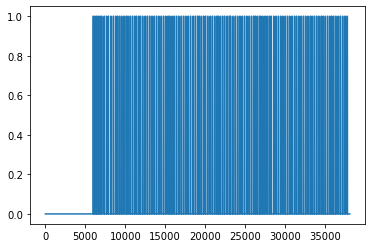

In [30]:
plt.plot(np.concatenate(downsampled_blue_light_trace_list))

spont
spont2
pre_neuron45_with_light
neuron45_with_light


NameError: name 'total_framenum' is not defined

In [25]:
blue_lightsampling_rate/frame_rate

463.4135038695028

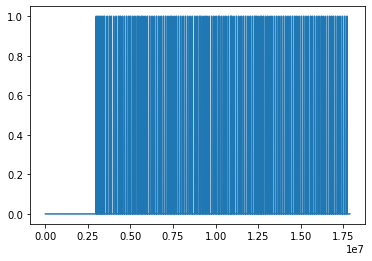

In [4]:
import matplotlib.pyplot as plt

plt.plot(lighton)